In [1]:
import os
os.environ["MAIN_DIR"] = ""

In [2]:
from rdkit import Chem
import pickle
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import tqdm
import json
import numpy as np
import itertools
from tabulate import tabulate
from torchdrug import data

from action_utils import *

In [3]:
start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

In [19]:
from multiprocessing import Pool
import time

main_df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
N = 100000
np.random.seed(42)
steps = 5

def generate_train_data(smile):
    mol = Chem.MolFromSmiles(smile)

    df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
    index = []
    
    # Get sequences
    try:
        for i in range(steps):
            actions = get_applicable_actions(mol)
            if actions.shape[0] == 0:
                break

            # Apply a random action
            rand_idx = np.random.randint(0, actions.shape[0])
            product = apply_action(mol, *actions.iloc[rand_idx])

            # Add it to df
            df.loc[df.shape[0], :] = [Chem.MolToSmiles(mol)] + actions.iloc[rand_idx].tolist() + [Chem.MolToSmiles(product)]
            index.append(actions.iloc[rand_idx].name)

            # Next reactant = product
            mol = product
    except Exception as e:
        return pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
    
    # Fix index
    df.index = index
    
    # Make combinations for multi-step possibilities of source-->target
    for i in range(df.shape[0]-1, 0, -1):
        new_df = df.iloc[:i].copy()
        new_df["product"] = df.iloc[i]["product"]
        df = pd.concat([df, new_df])
        
    return df

df_list = []
final_shape = 0
# Create dataset for 5 step pred
with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
    while final_shape < N:
        smiles = np.random.choice(start_mols, size=(1000,))

        for new_df in p.imap_unordered(generate_train_data, smiles, chunksize=10):
            df_list.append(new_df)
            final_shape += new_df.shape[0]
            
        pbar.update(final_shape - pbar.n)

main_df = pd.concat(df_list)
del df_list
print(main_df.shape)

# randomize
main_df = pd.concat([main_df[:int(main_df.shape[0]*0.8)].sample(frac=1), main_df[int(main_df.shape[0]*0.8):].sample(frac=1)])
print(main_df.shape)

107955it [02:26, 738.75it/s]                                                                         


(107955, 10)
(107955, 10)


# Networks

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
%matplotlib inline
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=1, hidden_size=50):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.ReLU())
            
        self.last_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.last_layer(out)
        return out

In [23]:
mse_model_path = "datasets/my_uspto/supervised_zinc_gin/mse_model.pth"

class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.GIN = torch.load("models/zinc2m_gin.pth")
        self.DENSE = torch.load(
            mse_model_path)
    
    def forward(self, x1, x2):
        out1 = self.GIN(x1, x1.node_feature.float())["graph_feature"]
        out2 = self.GIN(x2, x2.node_feature.float())["graph_feature"]
        
        out = torch.concatenate([out1, out2], axis=1)
        out = self.DENSE(out)
        return out

# Helper stuff

In [24]:
def molecule_from_smile(smile):
    try:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain")
    except Exception as e:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
    return mol

def get_mol_embedding(model, smiles):
    # deepchem - attribute masking
    if isinstance(smiles, str):
        mol = molecule_from_smile(smiles)
    else:
        mol = list(map(molecule_from_smile, smiles))
        mol = data.Molecule.pack(mol)
    mol = mol.to(device)
    emb = model(mol, mol.node_feature.float())["graph_feature"]
    return emb.detach().cpu().numpy()

def get_atom_embedding(model, smiles, idx):
    try:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain")
        emb = model(mol, mol.node_feature.float())["node_feature"][idx]
    except Exception as e:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
        emb = model(mol, mol.node_feature.float())["node_feature"][idx]
    return emb.detach().cpu()

def get_action_embedding(model, action_df):
    rsub, rcen, rsig, _, psub, pcen, psig, __ = [action_df[c] for c in action_df.columns]
#     print(get_mol_embedding(model, rsub).shape)
#     print(get_atom_embedding(model, rsig, rcen).shape)
#     print(get_mol_embedding(model, rsig).shape)
#     print(get_mol_embedding(model, psub).shape)
#     print(get_atom_embedding(model, psig, pcen).shape)
#     print(get_mol_embedding(model, psig).shape)
    embedding = np.concatenate([
#                         get_mol_embedding(model, rsub), 
#                         get_atom_embedding(model, rsig, rcen) / 5, 
                        get_mol_embedding(model, rsig), 
#                         get_mol_embedding(model, psub), 
#                         get_atom_embedding(model, psig, pcen) / 5, 
                        get_mol_embedding(model, psig)
                    ], axis=1)
    return embedding

In [25]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

def get_action_dataset_embeddings(model):
    action_embeddings = []
    for i in tqdm.tqdm(range(0, action_dataset.shape[0], batch_size)):
        action_embeddings.append(get_action_embedding(model, action_dataset.iloc[i:i+batch_size]))
    action_embeddings = np.concatenate(action_embeddings)
    return action_embeddings

(89384, 8)


In [26]:
def get_emb_indices_and_correct_idx(row):
    if isinstance(row, tuple): # For pandas iterrows
        row = row[1]
    
    # Applicable indices
    applicable_actions_df = get_applicable_actions(Chem.MolFromSmiles(row["reactant"]))
    if applicable_actions_df.shape[0] == 0:
        # If there are no applicable actions detected (rdkit problems)
        indices_used_for_data = np.where((action_dataset.index == row.name))[0]
        correct_idx = 0
    else:
        indices_used_for_data = np.where(action_dataset.index.isin(applicable_actions_df.index))[0]
        
        # Correct index
        applicable_actions_df = applicable_actions_df.loc[action_dataset.iloc[indices_used_for_data].index]
        correct_idx = (applicable_actions_df.index == row.name).argmax()

    
    return indices_used_for_data, correct_idx

# Training

In [27]:
actor_lr = 3e-4
epochs = 50
batch_size = 128

#####################
# Get actor network #
#####################
# actor = PolicyNetwork().to(device)#
actor = torch.load("models/supervised/emb_model_update=1||-ve_method=all||dist_metric=euclidean||topk=10/model.pth").to(device)
actor.eval() # Non-trainable for now
pass

In [28]:
################################################################
# Get inital embeddings and applicable_indices+correct_indices #
################################################################
action_embeddings = get_action_dataset_embeddings(actor.GIN)
print(action_embeddings.shape)

# I'm storing as lists, so doing numpy operations for the elements
correct_indices = []
action_embedding_indices = []

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
with Pool(20) as p:
    for indices_used_for_data, correct_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
        action_embedding_indices.append(indices_used_for_data)
        correct_indices.append(correct_idx)

        assert correct_indices[-1] < len(action_embedding_indices[-1]), f"WHAT!? {correct_indices[-1]} vs {len(indices_used_for_data)}"

100%|██████████████████████████████████████████████████████████████| 699/699 [05:43<00:00,  2.04it/s]


(89384, 256)


100%|███████████████████████████████████████████████████████| 107955/107955 [05:50<00:00, 308.24it/s]


In [29]:
# Make training data
def make_data(args):
    i, negative_topk = args
    data = []
    targets = []
    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[i]], correct_indices[i]

    # Positive
    positive = act_emb_for_i[correct_index]

    # Calc negatives
    dist = np.linalg.norm(action_embeddings - positive, axis=1)
    sorted_idx = np.argsort(dist)[:negative_topk] 
    sorted_idx = sorted_idx[sorted_idx != correct_index] # Remove correct index in list
    
    data = np.array([(i, correct_index)]+list(zip([i] * len(sorted_idx), sorted_idx)))
    targets = [[1] + [0] * len(sorted_idx)]
    return data, targets

train_X = []
train_Y = []
test_X = []
test_Y = []
with Pool(20) as p:
    bs = 100
    # Train
    start, end = 0, int(main_df.shape[0]*0.8)
    for X, Y in tqdm.tqdm(
                          p.imap_unordered(make_data, 
                                 [(i, 10) for i in range(start, end)], 
                                 chunksize=bs), 
                          total=(end-start)):
        train_X.append(X)
        train_Y.append(Y)
    
    # Test
    start, end = int(main_df.shape[0]*0.8), main_df.shape[0]
    for X, Y in tqdm.tqdm(
                          p.imap_unordered(make_data, 
                                 [(i, 1) for i in range(start, end)], 
                                 chunksize=bs), 
                          total=end-start):
        test_X.append(X)
        test_Y.append(Y)


train_X = np.concatenate(train_X, axis=0)
test_X = np.concatenate(test_X, axis=0)

100%|██████████████████████████████████████████████████████████| 21591/21591 [03:38<00:00, 98.72it/s]


In [30]:
%time train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_X[:, 0]]["reactant"])))
%time train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_X[:, 0]]["product"])))
%time train_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset.iloc[train_X[:, 1]]["rsig"])))
%time train_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset.iloc[train_X[:, 1]]["psig"])))

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_X[:, 0]]["reactant"])))
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_X[:, 0]]["product"])))
test_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset.iloc[test_X[:, 1]]["rsig"])))
test_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset.iloc[test_X[:, 1]]["psig"])))

train_Y = torch.Tensor(np.concatenate(train_Y, axis=1)).view(-1, 1)
test_Y = torch.Tensor(np.concatenate(test_Y, axis=1)).view(-1, 1)

print(train_reactants.batch_size, train_products.batch_size, train_rsigs.batch_size, train_psigs.batch_size, train_Y.shape)

print(test_reactants.batch_size, test_products.batch_size, test_rsigs.batch_size, test_psigs.batch_size, test_Y.shape)

CPU times: user 37min, sys: 2min 57s, total: 39min 58s
Wall time: 39min 35s
CPU times: user 47min 2s, sys: 5min 35s, total: 52min 38s
Wall time: 52min 4s
CPU times: user 20min 26s, sys: 1min 58s, total: 22min 25s
Wall time: 22min 13s
CPU times: user 24min 33s, sys: 2min 36s, total: 27min 10s
Wall time: 26min 52s
949971 949971 949971 949971 torch.Size([949971, 1])
43182 43182 43182 43182 torch.Size([43182, 1])


In [31]:
torch.cuda.empty_cache()    

NeuralNet(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=256, out_features=1, bias=True)
)
Epoch 1, Loss: 0.0003, Test Loss: 0.0242
Epoch 2, Loss: 0.0001, Test Loss: 0.0291
Epoch 3, Loss: 0.0002, Test Loss: 0.0357
Epoch 4, Loss: 0.0001, Test Loss: 0.0340
Epoch 5, Loss: 0.0001, Test Loss: 0.0273

FINAL TEST LOSS: 0.027308976261127597


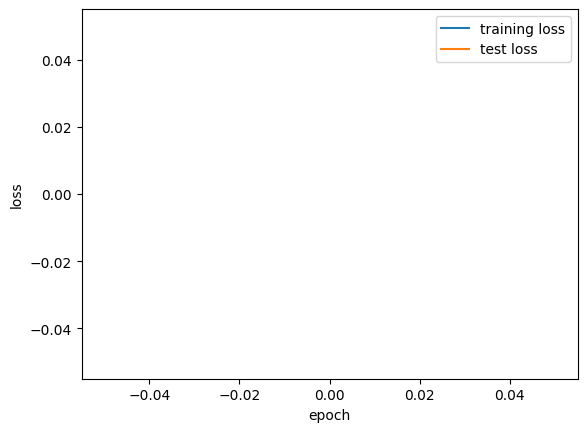

In [32]:
##########
# Critic #
##########
critic_lr = 1e-3
epochs = 5
num_hidden = 2
hidden_size = 256

class CriticNetwork(nn.Module):
    def __init__(self):
        super(CriticNetwork, self).__init__()
        self.GIN = torch.load("models/zinc2m_gin.pth")
        self.DENSE = NeuralNet(self.GIN.output_dim*4, 1, num_hidden=num_hidden, hidden_size=hidden_size).to(device)
    
    def forward(self, x1, x2, x3, x4):
        out1 = self.GIN(x1, x1.node_feature.float())["graph_feature"]
        out2 = self.GIN(x2, x2.node_feature.float())["graph_feature"]
        out3 = self.GIN(x3, x3.node_feature.float())["graph_feature"]
        out4 = self.GIN(x4, x4.node_feature.float())["graph_feature"]
        
        out = torch.concatenate([out1, out2, out3, out4], axis=1)
        out = self.DENSE(out)
        return out

torch.cuda.empty_cache()    
critic = CriticNetwork().to(device)
print(critic.DENSE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(critic.parameters(), lr=critic_lr)  

loss_list = []
test_loss = []

# Train the critic
for epoch in range(epochs):
    for i in range(0, train_reactants.batch_size - batch_size, batch_size):
        critic.train()
        # Forward pass
        outputs = critic(train_reactants[i:i+batch_size].to(device), 
                        train_products[i:i+batch_size].to(device), 
                        train_rsigs[i:i+batch_size].to(device), 
                        train_psigs[i:i+batch_size].to(device))
        loss = criterion(outputs, train_Y[i:i+batch_size].to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Free memory
        torch.cuda.empty_cache()    
    loss_list.append(loss.item())

    # Get test loss
    critic.eval()
    temp_test_loss = []
    for i in range(0, test_reactants.batch_size - batch_size, batch_size):
        temp_test_loss.append(
                        criterion(critic(test_reactants[i:i+batch_size].to(device), 
                                         test_products[i:i+batch_size].to(device), 
                                         test_rsigs[i:i+batch_size].to(device), 
                                         test_psigs[i:i+batch_size].to(device)) > 0.5, 
                                  test_Y[i:i+batch_size].to(device)).item()) 
        torch.cuda.empty_cache()    
    test_loss.append(np.mean(temp_test_loss))

    print ('Epoch {}, Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, loss_list[-1], test_loss[-1]))

print("\nFINAL TEST LOSS:", test_loss[-1])

plt.plot(loss_list[5:], label="training loss")
plt.plot(test_loss[5:], label="test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()



In [33]:
torch.save(critic, "models/supervised/critic/5step.pth")

In [ ]:
list(zip(critic(test_reactants, test_products, test_rsigs, test_psigs), train_Y))